In [1]:
import numpy as np
from scipy.sparse.linalg import aslinearoperator, lsqr
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF
from DynamicalSystems.reduced_rank_regression import reduced_rank_regression
import matplotlib.pyplot as plt

In [2]:
from stateinterpreter.descriptors import compute_descriptors
from stateinterpreter.utils.io import load_trajectory
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
traj = load_trajectory(traj_dict)
stride = 100
_data = compute_descriptors(traj[::stride], descriptors=['hbonds_distances'])[0].values

Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (5248, 318)


In [117]:
def implied_timescale(eigenvalues, stride, timestep):
    return -(stride*timestep)/np.log(np.abs(eigenvalues))

In [66]:
strides = [10 + 10*i for i in range(20)]
timestep = 0.2 #nanoseconds

In [73]:
implied_timescales = []
raw_evals = []
for stride in strides:
    print(f"Current stride: {stride}")
    _data = compute_descriptors(traj[::stride], descriptors=['hbonds_distances'])[0].values
    kernel = RBF(length_scale=np.float32(10))
    inputs = _data[:-1]
    evolved_inputs = _data[1:]
    regularizer = np.float32(1e-3)
    evals, evecs, _ = reduced_rank_regression(inputs, evolved_inputs, kernel, 5, regularizer=regularizer, center_kernel=True, _cumbersome_diagonalization=False)
    implied_timescales.append(implied_timescale(evals, stride, timestep))
    raw_evals.append(evals)

Current stride: 10
Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (52475, 318)
Current stride: 20
Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (26238, 318)
Current stride: 30
Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (17492, 318)
Current stride: 40
Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 1

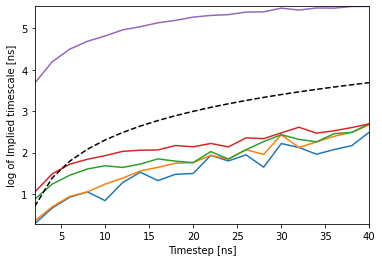

In [92]:
ts = [np.sort(x) for x in implied_timescales]
ts = np.array(ts)
plt.plot(np.array(strides)*timestep, np.log(ts))
plt.plot(np.array(strides)*timestep,np.log(np.array(strides)*timestep), 'k--')
plt.xlabel("Timestep [ns]")
plt.ylabel("log of Implied timescale [ns]")
plt.margins(0)

In [3]:
kernel = RBF(length_scale=np.float32(10))
inputs = _data[:-1]
evolved_inputs = _data[1:]
regularizer = np.float32(1e-3)
evals_old, evecs_old = reduced_rank_regression(inputs, evolved_inputs, kernel, 5, regularizer=regularizer, center_kernel=True, _cumbersome_diagonalization= True)
evals, evecs = reduced_rank_regression(inputs, evolved_inputs, kernel, 5, regularizer=regularizer, center_kernel=True, _cumbersome_diagonalization=False)

(-0.03591518914327026,
 0.9473569418303669,
 -0.032703757658600806,
 0.032703757658600806)

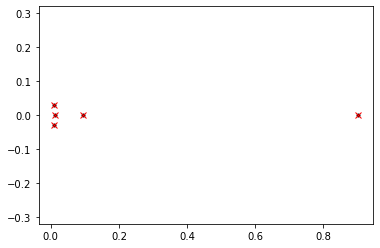

In [4]:
plt.plot(np.real(evals), np.imag(evals), 'k.')
plt.plot(np.real(evals_old), np.imag(evals_old), 'rx')
plt.axis("equal")

(-10.0, 10.0)

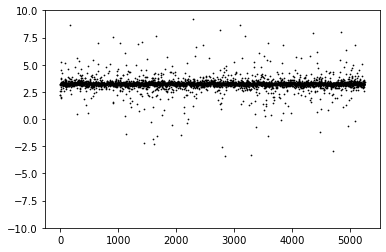

In [5]:
plt.scatter(np.arange(evecs.shape[0]), np.real(evecs[:,0]/evecs_old[:,0]), s=0.5, c='k')
plt.ylim(-10,10)

In [11]:
evecs_LS[:,0]/evecs_old[:,0]

array([-101364.60364024-0.j, -130323.6698626 +0.j,    5144.45445955+0.j,
       ...,   45848.59777697-0.j,   22479.85816868-0.j,
          5710.96234041-0.j])

In [14]:
import pylops
U = aslinearoperator(U)
U_pylops = pylops.LinearOperator(U, explicit=True)

In [10]:
evecs_LS = np.array([lsqr(U.T, evecs[:,i])[0] for i in range(len(evals))]).T
#evecs_ISTA = np.array([pylops.optimization.sparsity.ISTA(U_pylops, evecs[:,i], niter=1000)[0] for i in range(len(evals))]).T

In [127]:
evecs_LS/evecs_old

array([[ 6.39969447e+03    -0.j        , -9.86552549e+02    -0.j        ,
        -6.98966110e+02 -1304.79577449j,  1.39623816e+03  +690.13194069j,
        -5.89191719e+01 +1799.5385942j ],
       [-1.22000565e+04    +0.j        , -4.95817410e+03    +0.j        ,
        -8.19390158e+02  +652.18455749j, -4.63033785e+02  -352.59907994j,
        -5.21645473e+03  -111.86204579j],
       [ 4.57672366e+02    +0.j        ,  2.21809960e+03    +0.j        ,
        -3.15263048e+03+10208.04676266j,  6.73934444e+03+14023.42757109j,
         2.56343306e+04 +3833.4686821j ],
       ...,
       [ 2.34540236e+03    -0.j        , -2.39991755e+04    +0.j        ,
         4.49302033e+03 +1710.58262046j, -1.80936053e+03 +2574.9200601j ,
         6.85467735e+02  +463.43367097j],
       [-3.70050825e+02    -0.j        ,  1.09774208e+03    +0.j        ,
        -2.19127002e+02  -478.57944321j,  9.99433813e+01   +29.14017451j,
        -1.08729090e+01   +74.10841167j],
       [-1.33698792e+03    -0.j       

In [133]:
evecs_LS = evecs_LS.astype(U.dtype)

In [134]:
CVs = aslinearoperator(kernel(inputs))@evecs_LS
CVs_ISTA = aslinearoperator(kernel(inputs))@evecs_ISTA
CVs_old = aslinearoperator(kernel(inputs))@evecs_old
CVs_old = np.abs(CVs_old)
norm_LS = np.sqrt(U.shape[1])/np.linalg.norm(CVs[:,0])
norm_ISTA = np.sqrt(U.shape[1])/np.linalg.norm(CVs_ISTA[:,0])
norm_old = np.sqrt(U.shape[1])/np.linalg.norm(CVs_old[:,0])

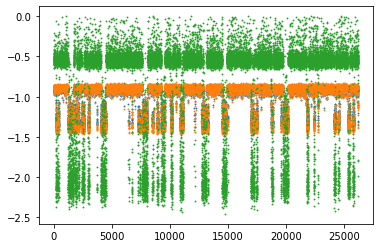

In [139]:
idx = 0
s = 0.7
plt.scatter(np.arange(CVs.shape[0]),CVs[:,idx]*norm_LS, s=s)
plt.scatter(np.arange(CVs.shape[0]),CVs_ISTA[:,idx]*norm_ISTA, s=s)
plt.scatter(np.arange(CVs.shape[0]),-CVs_old[:,idx]*norm_old, s=s)

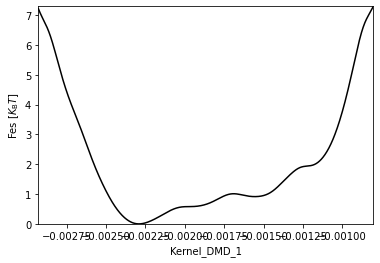

In [108]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
def f(x, CVs):
    kde = gaussian_kde(CVs[:,x][:,np.newaxis], bandwidth=0.00005)
    bounds = (CVs[:,x].min(),CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 1000)[:,np.newaxis]
    fes = -kde.logpdf(cv_sample)
    fes = fes - fes.min()
    plt.plot(cv_sample, fes, 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")
    full_fes = -kde.logpdf(CVs[:,x][:,np.newaxis])
    return full_fes - full_fes.min()
fes = f(1, CVs)
#fes = f(0, CVs)

In [90]:
folded_state_mask = fes < 0.5
folded_inputs = inputs[folded_state_mask]
folded_evolved_inputs = evolved_inputs[folded_state_mask]
folded_kernel = RBF(length_scale=5, unit_cell_length=unit_cell_length)

In [91]:
folded_evals, folded_evecs = reduced_rank_regression(folded_inputs, folded_evolved_inputs, folded_kernel, 10, regularizer=1e-2, backend='keops')

[pyKeOps] Compiling libKeOpsnumpy9dfb9da917 in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(((Exp((Minus(Square(Sqrt(Sum(Square(((Var(0,498,0) - Var(1,498,1)) - (Var(3,1,2) * Round(((Var(0,498,0) - Var(1,498,1)) / Var(2,1,2)),0)))))))) / IntCst(50))) / IntCst(15543)) * Var(4,1,1)),0)
       aliases: Var(0,498,0); Var(1,498,1); Var(2,1,2); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpsnumpy503a637d19 in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction((Exp((Minus(Square(Sqrt(Sum(Square(((Var(0,498,0) - Var(1,498,1)) - (Var(3,1,2) * Round(((Var(0,498,0) - Var(1,498,1)) / Var(2,1,2)),0)))))))) / IntCst(50))) * Var(4,1,1)),0)
       aliases: Var(0,498,0); Var(1,498,1); Var(2,1,2); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpsnumpyb3b5e022aa in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction(ComplexScal(Real2Complex((Exp((Min

(-0.021178915165364742,
 0.1778509197756648,
 -0.008116474049165845,
 0.008138010883703828)

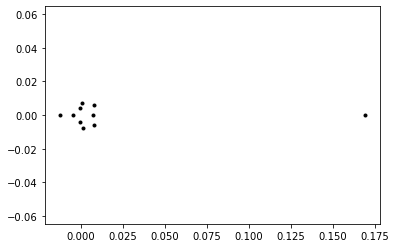

In [92]:
plt.plot(np.real(folded_evals), np.imag(folded_evals), 'k.')
plt.axis("equal")

In [93]:
folded_evals

array([ 1.68804109e-01+9.4063580e-08j, -1.21321045e-02-1.5522353e-05j,
        8.25649220e-03+6.0105533e-03j,  8.27604812e-03-6.0263043e-03j,
        1.13984477e-03+7.3991707e-03j,  7.21149053e-03+5.3596261e-05j,
        1.24128524e-03-7.3776338e-03j, -4.63351840e-03+7.9005782e-05j,
       -1.00566394e-04+4.0946244e-03j, -1.50503867e-04-4.1269767e-03j],
      dtype=complex64)

In [94]:
folded_CVs = aslinearoperator(folded_kernel(folded_inputs, backend='keops'))@folded_evecs
folded_CVs = np.real((folded_CVs - np.mean(folded_CVs, axis=0))/np.std(folded_CVs, axis = 0))
folded_CVs = np.abs(folded_CVs)

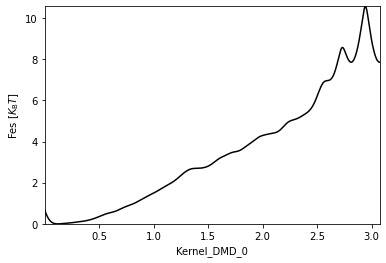

In [99]:
def f(x):
    kde = gaussian_kde(folded_CVs[:,x][:,np.newaxis], bandwidth=0.05)
    bounds = (folded_CVs[:,x].min(),folded_CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 5000)[:,np.newaxis]
    fes = -kde.logpdf(cv_sample)
    fes = fes - fes.min()
    plt.plot(cv_sample, fes, 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")
    full_fes = -kde.logpdf(folded_CVs[:,x][:,np.newaxis])
    return full_fes - full_fes.min()
fes = f(0)

In [105]:
import pandas as pd
from stateinterpreter.metastable import identify_metastable_states
from stateinterpreter.ml import Classifier, prepare_training_dataset

from stateinterpreter.descriptors import compute_descriptors
from stateinterpreter.utils.io import load_trajectory
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
traj = load_trajectory(traj_dict)

col_names = [f"Kernel_DMD_{idx}" for idx in range(CVs.shape[1])]
colvars = pd.DataFrame(CVs, columns=col_names)

descriptors, feats_info = compute_descriptors(traj[::20], descriptors=['hbonds_distances'])

Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (26238, 318)


In [106]:
cv_list = ["Kernel_DMD_0"]
kBT = 2.8
bandwidth=0.0015
states_labels = identify_metastable_states(colvars, cv_list, kBT, bandwidth, fes_cutoff=0.1*kBT, optimizer_kwargs={'num_init' : 50})

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 2 local minima with selected populations:
	Basin 0 -> 2381 configurations.
	Basin 1 -> 8694 configurations.


In [102]:
states_labels.shape

(26237, 2)

In [104]:
sample_obj, features_names, classes_names = prepare_training_dataset(descriptors[:-1], states_labels, 1000)
regularizers = np.geomspace(0.01, 1, 50)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)
classifier.plot();
reg = 10**(-0.5)
classifier.print_selected(reg)

/home/novelli/md-stateinterpreter/stateinterpreter/ml.py:54: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  states_subset = states_subset[states_subset != 'undefined' ]


ValueError: ('Lengths must match to compare', (26237,), (2,))

In [92]:
colvars['Kernel_DMD_0'][states_labels['selection'] & (states_labels['labels'] == 0)]

174      0.162944
176      0.156107
177      0.158152
178      0.156655
179      0.161578
           ...   
25858    0.156546
25859    0.164586
26232    0.163533
26234    0.162196
26235    0.156511
Name: Kernel_DMD_0, Length: 2381, dtype: float32

In [75]:
CVs[:,0]

array([0.17887408, 0.1782192 , 0.17653395, ..., 0.16219567, 0.15651083,
       0.17019448], dtype=float32)